In [34]:
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

In [35]:
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv("coinbaseUSD.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')    #timestamp to date
df.set_index(["Timestamp"], inplace= True)
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2014-12-01 05:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df.drop(["Open", "High", "Low", "Volume_(BTC)", "Volume_(Currency)", "Weighted_Price"], axis= 1, inplace= True)
df

,Close
Timestamp,
2014-12-01 05:33:00,300.00
2014-12-01 05:34:00,NaN
2014-12-01 05:35:00,NaN
2014-12-01 05:36:00,NaN
2014-12-01 05:37:00,NaN
...,...
2019-01-07 22:02:00,4006.01
2019-01-07 22:03:00,4006.01
2019-01-07 22:04:00,4006.01


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2099760 entries, 2014-12-01 05:33:00 to 2019-01-07 22:06:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Close   float64
dtypes: float64(1)
memory usage: 32.0 MB


In [40]:
df.isna().sum()

Close    109069
dtype: int64

In [41]:
df["Close"].fillna(method = "ffill", inplace = True)
df.isnull().sum()

Close    0
dtype: int64

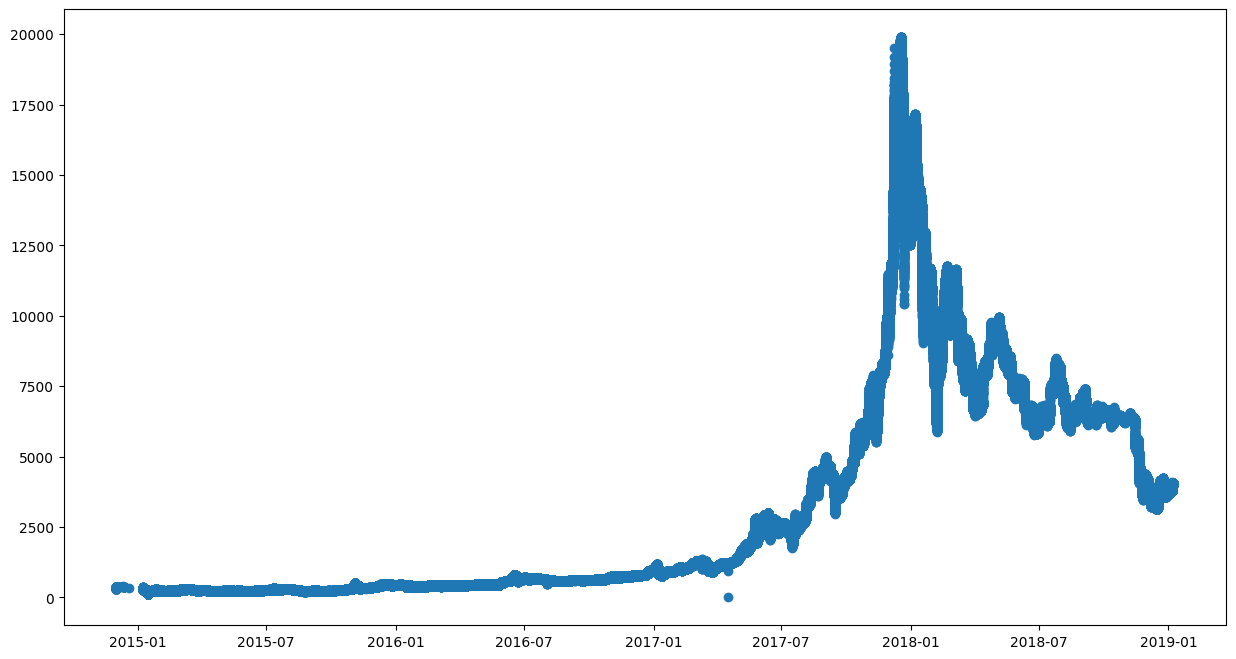

In [42]:
plt.figure(figsize=(15,8))
plt.scatter(df.index, df.Close)

In [ ]:
df.describe()

,Close
count,2.099760e+06
mean,3.106711e+03
std,3.756936e+03
min,6.000000e-02
25%,4.065000e+02
50%,9.041200e+02
75%,6.216000e+03
max,1.989199e+04


In [67]:
df = df.resample("5T").mean()
df.dropna(inplace=True)
df

,Close
Timestamp,
2014-12-01 05:30:00,300.000
2014-12-01 05:35:00,300.000
2014-12-01 05:40:00,300.000
2014-12-01 05:45:00,300.000
2014-12-01 05:50:00,300.000
...,...
2019-01-07 21:45:00,4015.590
2019-01-07 21:50:00,4010.948
2019-01-07 21:55:00,4007.380


In [ ]:
df["D"] = df.index.date
n_periods = df.pivot_table(index = ["D"], aggfunc = 'size').values

stats.describe(n_periods)

DescribeResult(nobs=1465, minmax=(1, 288), mean=286.661433447099, variance=336.6298299110388, skewness=-14.954382925131725, kurtosis=226.05813673541272)

In [ ]:
df.loc[df["D"] != df["D"].shift(), "Per"]  = n_periods
df.fillna(method = 'ffill', inplace = True)

df["Ret"] = np.where(df["D"] == df["D"].shift(),
                    ( (df["Close"]-df["Close"].shift()) * 1/df["Per"] ) **2, np.nan)

In [ ]:
rv = df.groupby("D")["Ret"].agg(np.sum).to_frame()
rv

,Ret
D,
2014-12-01,0.067608
2014-12-02,0.000410
2014-12-03,0.000020
2014-12-04,0.000105
2014-12-06,0.000000
...,...
2019-01-03,0.048973
2019-01-04,0.049550
2019-01-05,0.050929


In [ ]:
rv.columns = ["RV_daily"]
rv["RV_daily"] = np.sqrt(rv["RV_daily"])
rv.head(52)

,RV_daily
D,
2014-12-01,0.260016
2014-12-02,0.020246
2014-12-03,0.004478
2014-12-04,0.010227
2014-12-06,0.000000
2014-12-08,0.000000
2014-12-10,0.000000
2014-12-12,3.087403
2014-12-18,0.000000


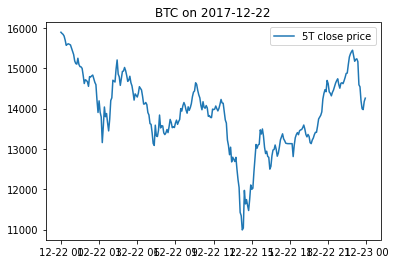

In [ ]:
date = str(rv["RV_daily"].idxmax())
plt.plot(df["Close"].loc[date], label = f"{sample} close price")
plt.title(f"BTC on {date}")
plt.legend()
plt.show()

In [ ]:
rv["RV_weekly"] = rv["RV_daily"].rolling(7).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(30).mean()
rv.dropna(inplace = True)
rv.tail()

,RV_daily,RV_weekly,RV_monthly
D,,,
2019-01-03,0.221298,0.400644,0.457511
2019-01-04,0.222597,0.336242,0.449968
2019-01-05,0.225675,0.281976,0.434444
2019-01-06,0.534852,0.303687,0.425050
2019-01-07,0.259766,0.288882,0.415706


In [ ]:
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])

p-value for daily RV: 0.16928770504624335
p-value for weekly RV: 0.07165499783477132
p-value for monthly RV: 0.04898781975324324


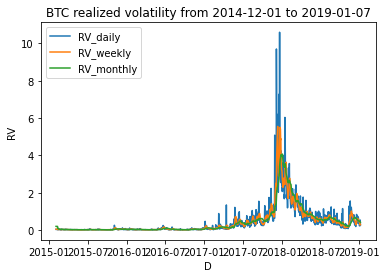

In [ ]:
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"BTC realized volatility from {df.index.date[0]} to {df.index.date[-1]}")
plt.ylabel("RV")
plt.show()

In [ ]:
rv["Target"] = rv["RV_daily"].shift(-1) #We want to predict the RV of the next day.  
rv.dropna(inplace = True)

#Scale the data
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())

#Add constant c
rv_scaled = sm.add_constant(rv_scaled)

#Split train and test sets
split = int(0.60 * rv.shape[0])
X = rv_scaled.drop("Target", axis = 1)
y = rv_scaled[["Target"]]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     280.0
Date:                Fri, 15 Apr 2022   Prob (F-statistic):          1.19e-126
Time:                        22:53:53   Log-Likelihood:                 3007.8
No. Observations:                 861   AIC:                            -6008.
Df Residuals:                     857   BIC:                            -5989.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.951      0.342      -0.000       0.001
RV_daily       0.3823      0.038     10.046      0.000       0.308       0.457
RV_weekly      0.1285      0.037      3.511      0.000       0.057       0.200
RV_monthly     0.1601      0.032      4.998      0.000       0.097       0.223
==============================================================================
Omnibus:                     1265.892   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           500530.631
Skew:                           8.154   Prob(JB):                         0.00
Kurtosis:                     119.988   Cond. No.                         195.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

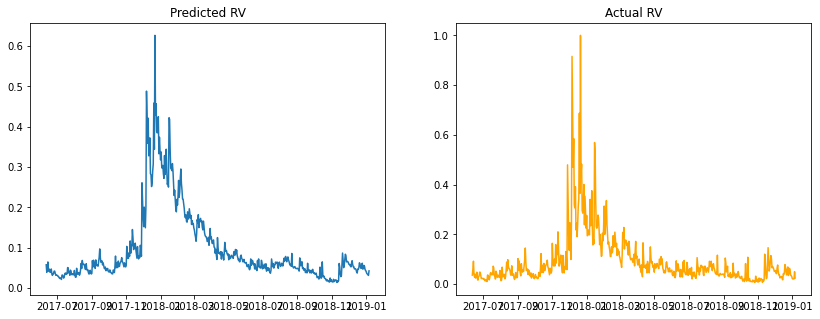

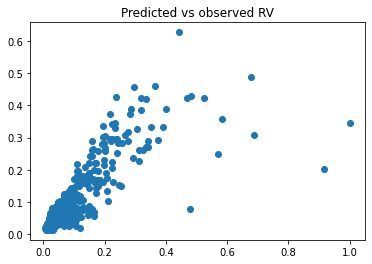

In [ ]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted RV")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

In [ ]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [ ]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:5.4104195600095334e-05, R^2:0.4950077770960951, MAE:0.0024532571136746833
----------------
Out-of-sample scores
MSE:0.003920557708278651, R^2:0.6500087845214788, MAE:0.030521300084635255


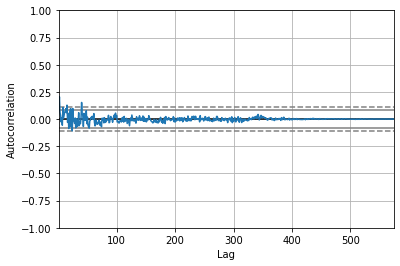

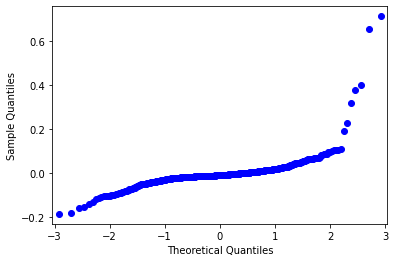

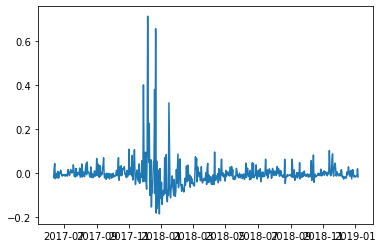

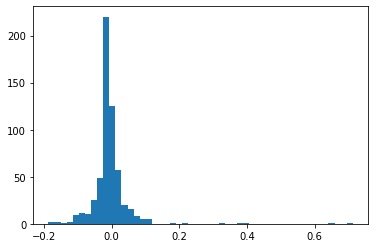

In [ ]:
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()